In [1]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os

# Visialisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# Machine Learning

# Utils
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn import preprocessing

#Feature Selection
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold

# Metrics
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

# Models
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
raw = pd.read_csv("TCGA_selected_features_213.csv")
raw = raw.drop_duplicates(subset = 'ID')
new_feature = raw.copy()
new_feature = new_feature[~new_feature['ID'].str.contains("ENSG")]
new_feature['ID'] = new_feature['ID'].astype('int')
new_feature=new_feature.drop({'LogFC'},axis = 1)


# raw = pd.read_csv("TCGA_selected_features_new.csv")
# raw = raw.drop_duplicates(subset = 'ID')
# new_feature = raw[raw['Group']!=999]
# new_feature['ID'] = new_feature['ID'].astype('int')
# new_feature=new_feature.drop({'LogFC'},axis = 1)

In [3]:
new_feature

,Symbol,Group,ID,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,Disease_ProstateCancer_Causing,GO_ComplementActivation_NlogP,GO_ExtracellularRegion_NlogP,GO_ExtracellularRegion_Causing,GO_ExtracellularSpace_NlogP,GO_ExtracellularSpace_Causing,Path_CellCycleMitotic_NlogP,Path_CellCycleMitotic_Causing,Path_MatrixMetalloproteinases_NlogP,Path_MatrixMetalloproteinases_Causing,System_CardiovascularSystem_NlogP,System_CardiovascularSystem_Causing,System_ExtraembryonicTissues_NlogP,System_ExtraembryonicTissues_Causing,System_GastrointestinalTract_NlogP,System_GastrointestinalTract_Causing,System_HematopoieticSystem_NlogP,System_HematopoieticSystem_Causing,System_IntegumentarySystem_NlogP,System_IntegumentarySystem_Causing,System_MuscoskeletalSystem_NlogP,System_MuscoskeletalSystem_Causing,System_NervousSystem_NlogP,System_NervousSystem_Score,System_NervousSystem_Causing,System_ReproductiveSystem_NlogP,System_ReproductiveSystem_Score,System_ReproductiveSystem_Causing,System_RespiratorySystem_NlogP,System_RespiratorySystem_Causing,System_SensoryOrgans_NlogP,System_SensoryOrgans_Causing,Tissue_Blood_NlogP,Tissue_Blood_Score,Tissue_Blood_Causing,Tissue_Bone_NlogP,Tissue_Bone_Score,Tissue_Bone_Causing,Tissue_Brain_NlogP,Tissue_Brain_Score,Tissue_Brain_Causing,Tissue_Cartilage_NlogP,Tissue_Cartilage_Causing,Tissue_Endothelium_NlogP,Tissue_Endothelium_Causing,Tissue_Epithelial_NlogP,Tissue_Epithelial_Score,Tissue_Epithelial_Causing,Tissue_Eye_NlogP,Tissue_Eye_Score,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing
0,PYCR1,P,5831,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,0.939546,0.733849,0.946866,0.733849,0.0,0.000000,0.000000,0.981339,0.733849,0.0,0.0,0.000000,0.00000,1.101574,0.733849,0.0,0.0,1.050493,0.733849,0.000000,0.000000,0.0,0.0,1.385521,0.733849,0.907849,3.65,0.733849,0.870026,0.63,0.733849,0.000000,0.000000,0.000000,0.000000,0.813203,2.98,0.733849,1.660855,9.64,0.733849,0.458297,2.15,0.733849,0.783771,0.733849,0.000000,0.000000,0.223725,0.73,0.733849,1.455859,5.75,0.733849,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849
1,TEDC2,P,80178,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.563540,0.716524,0.000000,0.000000,0.0,0.000000,0.000000,0.940436,0.716524,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.313990,0.42,0.716524,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,FAM83A,P,84985,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,1.208603,0.140032,0.000000,0.000000,0.0,0.000000,0.000000,0.940436,0.140032,0.0,0.0,0.000000,0.00000,0.721775,0.140032,0.0,0.0,0.753401,0.140032,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.124088,0.54,0.140032,0.467691,0.77,0.140032,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.688209,1.58,0.140032,0.282957,0.29,0.140032,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000
3,IQGAP3,P,128239,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,1.290103,0.287367,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.239689,0.287367,0.179004,0.16,0.287367,0.559941,0.30,0.287367,0.000000,0.000000,0.000000,0.000000,0.387345,1.21,0.287367,0.608129,1.21,0.287367,0.455519,2.15,0.287367,0.000000,0.000000,0.000000,0.000000,0.703161,1.62,0.2

In [44]:
Big_X = new_feature.drop({'Symbol', 'Group', 'ID'},axis = 1)
ggg = []
for i in list(new_feature['Group']):
    if i == 'P':
        ggg.append(1)
    else:
        ggg.append(0)
Big_Y =pd.Series(ggg)

In [45]:
type(Big_Y)

pandas.core.series.Series

In [46]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = train_test_split(Big_X,Big_Y,train_size=2300, stratify=Big_Y,random_state=42)



In [47]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, test_size=400, stratify=y_test,random_state=42)

In [48]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [49]:
seed_everything()

In [50]:
def get_tabnet_model():
    classifier = TabNetClassifier(
      n_d=64, n_a=64, n_steps=5,
      # gamma=1.5, n_independent=2, n_shared=2,
      # lambda_sparse=1e-4, momentum=0.1,
      optimizer_fn=torch.optim.Adam,
      optimizer_params=dict(lr=2e-2),
      # scheduler_fn=torch.optim.lr_scheduler.StepLR,
      # scheduler_params = {"gamma": 0.95, "step_size": 20},
      verbose=1, seed=42)

    return classifier

In [51]:
EPOCHS = 200

In [52]:
best_clf = None
best_score = 10000
all_clfs = []


classifier = get_tabnet_model()

classifier.fit(X_train.to_numpy(), y_train,
                 eval_set=[(X_valid.to_numpy(), y_valid)],
                 eval_name=['valid'],
                 patience=20,
                 max_epochs=EPOCHS,
                #  batch_size=1024,
                #  virtual_batch_size=256,
                 eval_metric=['auc'])
print(' ')
# preds = classifier.predict(X_valid)
pred_prob = classifier.predict_proba(X_valid.to_numpy())
# print(f'Accuracy: {round(accuracy_score(y_valid, preds), 5)}')
print(f'Log Loss: {round(log_loss(y_valid, pred_prob), 5)}')
print(f'AUC: {round(roc_auc_score(y_valid, pred_prob[:,1]), 5)}')
if round(log_loss(y_valid, pred_prob), 5) < best_score:
    best_score = round(log_loss(y_valid, pred_prob), 5)
    best_clf = classifier
all_clfs.append(classifier)
print('***********************************************************')
print(' ')

Device used : cpu
epoch 0  | loss: 1.36704 | valid_auc: 0.47314 |  0:00:00s
epoch 1  | loss: 0.92811 | valid_auc: 0.56723 |  0:00:00s
epoch 2  | loss: 0.88509 | valid_auc: 0.59734 |  0:00:01s
epoch 3  | loss: 0.80446 | valid_auc: 0.5845  |  0:00:01s
epoch 4  | loss: 0.73318 | valid_auc: 0.55868 |  0:00:02s
epoch 5  | loss: 0.70094 | valid_auc: 0.58888 |  0:00:02s
epoch 6  | loss: 0.65874 | valid_auc: 0.60765 |  0:00:03s
epoch 7  | loss: 0.63089 | valid_auc: 0.65945 |  0:00:03s
epoch 8  | loss: 0.62047 | valid_auc: 0.69505 |  0:00:04s
epoch 9  | loss: 0.65033 | valid_auc: 0.66294 |  0:00:04s
epoch 10 | loss: 0.70678 | valid_auc: 0.68754 |  0:00:04s
epoch 11 | loss: 0.63252 | valid_auc: 0.68105 |  0:00:05s
epoch 12 | loss: 0.60711 | valid_auc: 0.68669 |  0:00:05s
epoch 13 | loss: 0.60248 | valid_auc: 0.77401 |  0:00:06s
epoch 14 | loss: 0.59695 | valid_auc: 0.76759 |  0:00:06s
epoch 15 | loss: 0.58784 | valid_auc: 0.74776 |  0:00:07s
epoch 16 | loss: 0.60194 | valid_auc: 0.70364 |  0:00:

In [53]:
print(f'AUC: {round(roc_auc_score(y_test, best_clf.predict_proba(X_test.to_numpy())[:,1]), 5)}')

AUC: 0.78341


In [66]:
len(list(best_clf.predict_proba(X_test.to_numpy())[:,1]))

400

In [72]:
other_Test = pd.DataFrame()
other_Test['Target'] = list(y_test)
other_Test['TabNet'] =list(best_clf.predict_proba(X_test.to_numpy())[:,1])
other_Test['rf'] =list(y_test_proba_rf)
other_Test['xgb'] =list(y_test_proba_xgb)
other_Test['GCN'] =list(y_test_proba_ada)

In [73]:
other_Test

,Target,TabNet,rf,xgb,GCN
0,1,0.793765,0.662791,0.653025,0.544269
1,1,0.471984,0.918811,0.749733,0.517575
2,1,0.468848,0.930461,0.749733,0.527155
3,0,0.254059,0.442893,0.354306,0.491469
4,0,0.488066,0.626541,0.553235,0.486381
...,...,...,...,...,...
395,1,0.382092,0.789114,0.570688,0.506209
396,1,0.254752,0.445113,0.450958,0.496377
397,1,0.388614,0.700101,0.559251,0.519344
398,0,0.679121,0.638585,0.653798,0.494651


In [74]:
other_Test_ada = pd.DataFrame()
other_Test_ada['Target'] = list(y_valid)
other_Test_ada['ada'] =list(y_valid_proba_ada)

In [75]:
other_Test_ada

,Target,ada
0,0,0.482114
1,1,0.506451
2,0,0.489489
3,0,0.573351
4,0,0.476246
...,...,...
386,0,0.466422
387,0,0.474048
388,0,0.552249
389,0,0.502058


In [76]:
other_Test.to_csv('out.csv',index = False)
other_Test_ada.to_csv('outada.csv',index = False)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [14]:
X,y = Big_X,Big_Y

In [15]:
rf0 = RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(X,y)
print (rf0.oob_score_)
y_predprob = rf0.predict_proba(X)[:,1]
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y,y_predprob))

0.7703008735037205
AUC Score (Train): 0.998311


In [16]:
param_test1= {'n_estimators':range(10,150,10)}
gsearch1= GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                 min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10),
                       param_grid =param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X,y)



GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, max_features='sqrt',
                                              min_samples_leaf=20,
                                              min_samples_split=100,
                                              random_state=10),
             param_grid={'n_estimators': range(10, 150, 10)},
             scoring='roc_auc')

In [17]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 130}, 0.8260208107237457)

In [18]:
param_test2= {'max_depth':range(3,21,2), 'min_samples_split':range(10,101,20)}
gsearch2= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 130,
                                 min_samples_leaf=20,max_features='sqrt' ,oob_score=True,random_state=10),
   param_grid = param_test2,scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X,y)



GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              min_samples_leaf=20,
                                              n_estimators=130, oob_score=True,
                                              random_state=10),
             iid=False,
             param_grid={'max_depth': range(3, 21, 2),
                         'min_samples_split': range(10, 101, 20)},
             scoring='roc_auc')

In [19]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 11, 'min_samples_split': 10}, 0.8305741176762107)

In [20]:

rf1= RandomForestClassifier(n_estimators= 130, max_depth=11, min_samples_split=10,
                                 min_samples_leaf=20,max_features='sqrt' ,oob_score=True,random_state=10)
rf1.fit(X_train,y_train)
print(rf1.oob_score_)



0.7171428571428572


In [21]:
param_test3= {'min_samples_split':range(5,15,1), 'min_samples_leaf':range(10,60,10)}
gsearch3= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 130,max_depth=11,
                                 max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3,scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(X,y)



GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=11, max_features='sqrt',
                                              n_estimators=130, oob_score=True,
                                              random_state=10),
             iid=False,
             param_grid={'min_samples_leaf': range(10, 60, 10),
                         'min_samples_split': range(5, 15)},
             scoring='roc_auc')

In [22]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 10, 'min_samples_split': 5}, 0.8359185710051931)

In [23]:
param_test4= {'max_features':range(3,11,2)}
gsearch4= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 130 ,max_depth=11, min_samples_split=5,
                                 min_samples_leaf=10 ,oob_score=True, random_state=10),
   param_grid = param_test4,scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(X,y)



GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=11, min_samples_leaf=10,
                                              min_samples_split=5,
                                              n_estimators=130, oob_score=True,
                                              random_state=10),
             iid=False, param_grid={'max_features': range(3, 11, 2)},
             scoring='roc_auc')

In [24]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 7}, 0.8364272056136237)

In [25]:
from sklearn.metrics import log_loss

In [26]:

rf2= RandomForestClassifier(n_estimators= 130 ,max_depth=11, min_samples_split=5,
                            min_samples_leaf=10 ,oob_score=True,
                            max_features = 7,random_state=10)
rf2.fit(X_train,y_train)



RandomForestClassifier(max_depth=11, max_features=7, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=130, oob_score=True,
                       random_state=10)

In [27]:
# rf2.oob_score_

In [54]:
y_train_proba_rf = rf2.predict_proba(X_train)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_proba_rf))

y_valid_proba_rf = rf2.predict_proba(X_valid)[:,1]
print("AUC Score (valid): %f" % metrics.roc_auc_score(y_valid, y_valid_proba_rf))

y_test_proba_rf = rf2.predict_proba(X_test)[:,1]
print("AUC Score (test): %f" % metrics.roc_auc_score(y_test, y_test_proba_rf))

AUC Score (Train): 0.819773
AUC Score (valid): 0.785491
AUC Score (test): 0.813692


In [55]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

0.8136921672077922


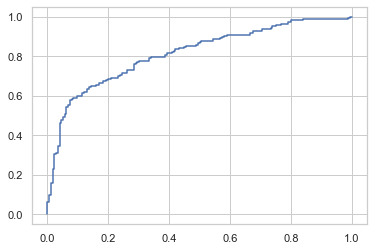

In [56]:
fpr, tpr, thres = roc_curve(y_test,y_test_proba_rf)
print (auc(fpr, tpr))
plt.plot(fpr, tpr, label = "AUROC = {:.2f}".format(auc(fpr, tpr)))

In [57]:
from xgboost import XGBClassifier

In [58]:

xgbclf = XGBClassifier(learning_rate=0.01,
                        eval_metric ="auc",
                        objective = "binary:logistic",
                       n_estimators=100,           # 树的个数-10棵树建立xgboost
                       max_depth=4,               # 树的深度
                       min_child_weight = 1,      # 叶子节点最小权重
                       gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                       subsample=1,               # 所有样本建立决策树
                       scale_pos_weight=1,        # 解决样本个数不平衡的问题
                       random_state=27,           # 随机数
                      )
xgbclf.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
y_train_proba_xgb = xgbclf.predict_proba(X_train)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_proba_xgb))

y_valid_proba_xgb = xgbclf.predict_proba(X_valid)[:,1]
print("AUC Score (valid): %f" % metrics.roc_auc_score(y_valid, y_valid_proba_xgb))

y_test_proba_xgb = xgbclf.predict_proba(X_test)[:,1]
print("AUC Score (test): %f" % metrics.roc_auc_score(y_test, y_test_proba_xgb))

AUC Score (Train): 0.873557
AUC Score (valid): 0.818410
AUC Score (test): 0.832120


0.8321200284090909


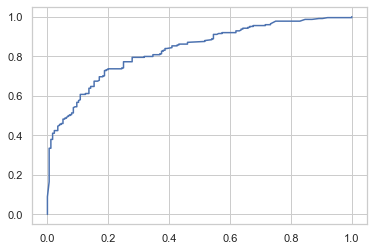

In [60]:
# y_predprob = xgbclf.predict_proba(X)[:,1]
fpr, tpr, thres = roc_curve(y_test,y_test_proba_xgb)
print (auc(fpr, tpr))
plt.plot(fpr, tpr, label = "AUROC = {:.2f}".format(auc(fpr, tpr)))

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [62]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth= 3, min_samples_split=26, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=180, learning_rate=0.8)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_leaf=5,
                                                         min_samples_split=26),
                   learning_rate=0.8, n_estimators=180)

In [63]:
y_train_proba_ada = bdt.predict_proba(X_train)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_proba_ada))

y_valid_proba_ada = bdt.predict_proba(X_valid)[:,1]
print("AUC Score (valid): %f" % metrics.roc_auc_score(y_valid, y_valid_proba_ada))

y_test_proba_ada = bdt.predict_proba(X_test)[:,1]
print("AUC Score (test): %f" % metrics.roc_auc_score(y_test, y_test_proba_ada))

AUC Score (Train): 0.973707
AUC Score (valid): 0.853980
AUC Score (test): 0.868583


0.8685825892857142


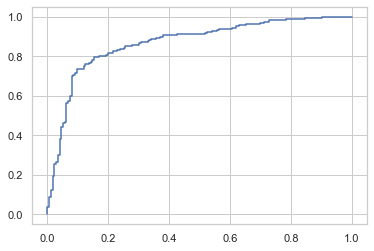

In [64]:
fpr, tpr, thres = roc_curve(y_test,y_test_proba_ada)
print (auc(fpr, tpr))
plt.plot(fpr, tpr, label = "AUROC = {:.2f}".format(auc(fpr, tpr)))